# Notebook 01: Sovereign Risk Dashboard (10YR vs. Gold)
#
# **Pair:** 10YR Treasury Futures (/ZB) vs. Gold Futures (/GC)
# **Thesis:** Tracking the breakdown of the classic "safe haven" correlation.
# In a classic risk-off, /ZB (price) and /GC rise together.
# In the new "Sovereign Risk / De-Dollarization" regime, /ZB falls (yields rise)
# while /GC rises, signaling a loss of faith in U.S. debt as a haven.
#
# **Proxies Used:**
# * `/ZB=F` (T-Note Future) -> `TLT` (20+ Yr Treasury ETF for clean price history)
# * `/GC=F` (Gold Future)   -> `GLD` (Gold ETF for clean price history)
#
# **Causal Drivers (OSINT):**
# * `DFII10`: 10-Yr Real Yield (TIPS). The #1 driver. Gold (non-yielding) should move inversely to this.
# * `T10YIE`: 10-Yr Breakeven Inflation.
# * `DTWEXBGS`: Trade-Weighted U.S. Dollar Index.

In [1]:
# Cell 1: Imports
#
# Import all necessary libraries for data, analysis, and visualization.
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import requests
import os
import json
from datetime import datetime, timedelta

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Cell 1: Libraries imported successfully.")

✅ Cell 1: Libraries imported successfully.


In [2]:
# Cell 2: API & LLM Configuration
#
# Set up API keys, LLM endpoints, and asset tickers.

# --- FRED API Configuration ---
# ❗️ REQUIRES YOUR KEY: Get one from https://fred.stlouisfed.org/
os.environ.setdefault("FRED_API_KEY", "24a7e70f4690fbab7d2571d335107c68")

# --- LLM Configuration (Reused from your example) ---
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434") # Local Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b") # Your preferred model

def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"

    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }
    
    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        return f"Error connecting to LLM at {url_to_use}. Is Ollama running?"

# --- Asset & Driver Configuration ---
YFINANCE_TICKERS = ["GLD", "TLT"]
FRED_SERIES_IDS = ["DFII10", "T10YIE", "DTWEXBGS"]

# --- Date Range Configuration ---
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5 * 365) # 5 years of data

print("✅ Cell 2: Configuration loaded.")
print(f"Fetching data for: {YFINANCE_TICKERS} and {FRED_SERIES_IDS}")

✅ Cell 2: Configuration loaded.
Fetching data for: ['GLD', 'TLT'] and ['DFII10', 'T10YIE', 'DTWEXBGS']


In [3]:
# Cell 3: Data Collection - yfinance
#
# Fetch historical price data for our ETF proxies (GLD, TLT).
# We only care about the 'Adj Close' which accounts for dividends/splits.
try:
    print(f"Fetching yfinance data from {START_DATE.date()} to {END_DATE.date()}...")

    yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)

    # Select the 'Close' column for each ticker
    df_yf = yf_data.xs('Close', level=0, axis=1).copy()
    df_yf.index = pd.to_datetime(df_yf.index)

    print("✅ Cell 3: yfinance data fetched successfully.")
    print(df_yf.tail())
except Exception as e:
    print(f"❌ Cell 3: yfinance data fetch failed: {e}")



Fetching yfinance data from 2020-11-04 to 2025-11-03...


/tmp/ipykernel_700980/1882999288.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  2 of 2 completed

✅ Cell 3: yfinance data fetched successfully.
Ticker             GLD        TLT
Date                             
2025-10-27  367.010010  91.779999
2025-10-28  364.380005  92.019997
2025-10-29  363.000000  91.089996
2025-10-30  370.130005  90.559998
2025-10-31  368.119995  90.290001


In [4]:
# Cell 4: Data Collection - FRED
#
# Fetch historical macro data for our causal drivers from FRED.
try:
    print("Fetching FRED data...")
    fred = Fred(api_key=os.getenv("FRED_API_KEY"))
    
    df_fred_list = []
    for series_id in FRED_SERIES_IDS:
        series = fred.get_series(series_id, START_DATE, END_DATE)
        df_fred_list.append(series.rename(series_id))
        
    df_fred = pd.concat(df_fred_list, axis=1)
    df_fred.index = pd.to_datetime(df_fred.index)

    print("✅ Cell 4: FRED data fetched successfully.")
    print(df_fred.tail())

except Exception as e:
    print(f"❌ Cell 4: FRED data fetch failed. Is your API key correct?")
    print(e)

Fetching FRED data...
✅ Cell 4: FRED data fetched successfully.
            DFII10  T10YIE  DTWEXBGS
2025-10-27    1.73    2.28       NaN
2025-10-28    1.71    2.28       NaN
2025-10-29    1.78    2.30       NaN
2025-10-30    1.82    2.29       NaN
2025-10-31     NaN    2.30       NaN


In [5]:
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market) and FRED (macro) data into a single DataFrame.
# Use 'outer' join to keep all dates, then 'ffill' to fill weekends/holidays.
try:
    df = pd.merge(df_yf, df_fred, left_index=True, right_index=True, how='outer')
    
    # Forward-fill missing values (e.g., FRED data on non-market days, or vice-versa)
    df = df.ffill()
    
    # Drop any initial NaNs from the start of the dataset
    df = df.dropna()
    
    print("✅ Cell 5: Data consolidated and cleaned.")
    print(df.tail())
    
except Exception as e:
    print(f"❌ Cell 5: Data merge failed: {e}")

✅ Cell 5: Data consolidated and cleaned.
                   GLD        TLT  DFII10  T10YIE  DTWEXBGS
2025-10-27  367.010010  91.779999    1.73    2.28   121.342
2025-10-28  364.380005  92.019997    1.71    2.28   121.342
2025-10-29  363.000000  91.089996    1.78    2.30   121.342
2025-10-30  370.130005  90.559998    1.82    2.29   121.342
2025-10-31  368.119995  90.290001    1.82    2.30   121.342


In [6]:
# Cell 6: Feature Engineering - Normalization (Z-Scores)
#
# Normalize all data to compare them on the same scale.
# A Z-Score tells us how many standard deviations a value is from its mean.
# This is critical for comparing yields (e.g., 4.5) to prices (e.g., 200).

try:
    df_normalized = df.apply(zscore)
    
    print("✅ Cell 6: Data normalized (Z-Scores).")
    print(df_normalized.describe()) # Describe shows mean ~0, std ~1
    
except Exception as e:
    print(f"❌ Cell 6: Normalization failed: {e}")

✅ Cell 6: Data normalized (Z-Scores).
                GLD           TLT        DFII10        T10YIE      DTWEXBGS
count  1.303000e+03  1.303000e+03  1.303000e+03  1.303000e+03  1.303000e+03
mean  -3.053752e-16 -3.926253e-16  8.725007e-17 -2.137627e-15 -1.570501e-15
std    1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00
min   -1.021445e+00 -1.408453e+00 -1.719004e+00 -3.808822e+00 -1.974946e+00
25%   -6.706025e-01 -7.776308e-01 -1.260863e+00 -4.305531e-01 -8.801266e-01
50%   -4.624164e-01 -4.597679e-01  5.027759e-01 -4.913557e-02  1.905595e-01
75%    4.035762e-01  1.068717e+00  8.352321e-01  3.867701e-01  6.374384e-01
max    3.848216e+00  2.220836e+00  1.289319e+00  3.710551e+00  2.191024e+00


In [7]:
# Cell 7: Feature Engineering - Ratios & Spreads
#
# Calculate the key ratios and spreads that define our thesis.
#
# * Ratio: The price of GLD divided by the price of TLT. A rising ratio
#     means Gold is outperforming Treasuries (our thesis).
# * Spread (Normalized): The normalized Z-score of GLD minus the
#     normalized Z-score of TLT. This shows the *magnitude* of the divergence.

try:
    # 1. Price Ratio (The Core Signal)
    df['GLD_TLT_Ratio'] = df['GLD'] / df['TLT']
    
    # 2. Normalized Price Spread (Divergence Magnitude)
    df['GLD_TLT_Spread_Norm'] = df_normalized['GLD'] - df_normalized['TLT']
    
    # 3. Causal Spread (Gold vs. Real Yields)
    # This *should* be negative. If it turns positive, the relationship is broken.
    df['GLD_DFII10_Spread_Norm'] = df_normalized['GLD'] - df_normalized['DFII10']

    print("✅ Cell 7: Ratios and Spreads calculated.")
    print(df[['GLD_TLT_Ratio', 'GLD_TLT_Spread_Norm', 'GLD_DFII10_Spread_Norm']].tail())
    
except Exception as e:
    print(f"❌ Cell 7: Ratio/Spread calculation failed: {e}")

✅ Cell 7: Ratios and Spreads calculated.
            GLD_TLT_Ratio  GLD_TLT_Spread_Norm  GLD_DFII10_Spread_Norm
2025-10-27       3.998802             3.663282                2.500891
2025-10-28       3.959792             3.598649                2.466270
2025-10-29       3.985070             3.625426                2.382833
2025-10-30       4.087125             3.793713                2.488223
2025-10-31       4.077085             3.770377                2.449369


In [8]:
# Cell 8: Feature Engineering - Rolling Correlations
#
# Calculate the 30-day and 90-day rolling correlations between
# the *daily returns* of GLD and TLT.
# This directly quantifies the "correlation breakdown" over time.

try:
    # First, get daily percentage returns
    df['GLD_pct'] = df['GLD'].pct_change()
    df['TLT_pct'] = df['TLT'].pct_change()
    
    # Calculate rolling correlations
    df['Corr_30D'] = df['GLD_pct'].rolling(window=30).corr(df['TLT_pct'])
    df['Corr_90D'] = df['GLD_pct'].rolling(window=90).corr(df['TLT_pct'])

    print("✅ Cell 8: Rolling correlations calculated.")
    print(df[['Corr_30D', 'Corr_90D']].tail())

except Exception as e:
    print(f"❌ Cell 8: Correlation calculation failed: {e}")

✅ Cell 8: Rolling correlations calculated.
            Corr_30D  Corr_90D
2025-10-27  0.005387  0.162123
2025-10-28 -0.000802  0.178168
2025-10-29  0.011054  0.183668
2025-10-30 -0.050887  0.167759
2025-10-31 -0.033744  0.154828


Plotting Cell 9: Core Thesis...


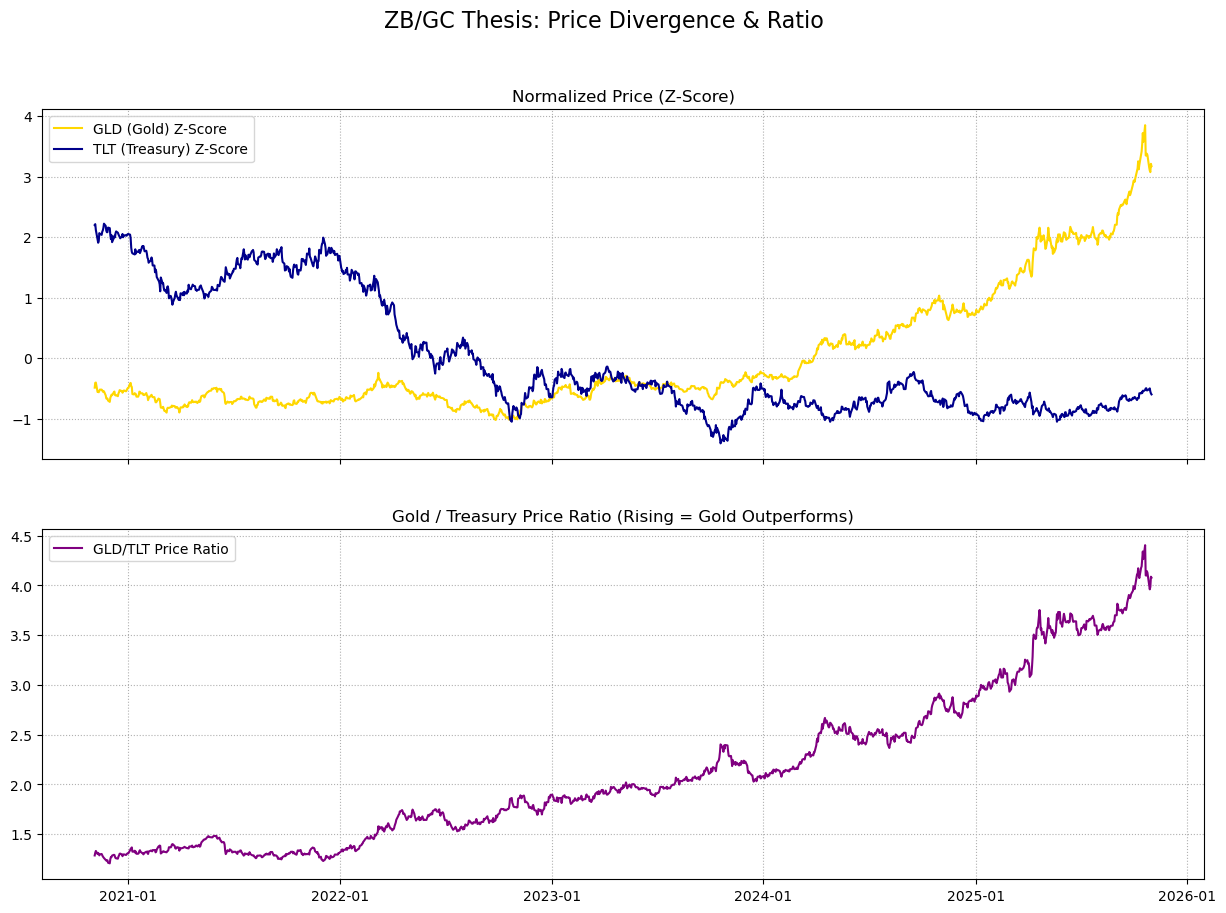

In [9]:
# Cell 9: Visualization - Core Thesis (Price vs. Ratio)
#
# Plot 1: Normalized prices of GLD vs. TLT.
# Plot 2: The GLD/TLT Ratio.
#
# This chart shows *what* is happening. Are they diverging? Is the ratio
# in a clear uptrend?

try:
    print("Plotting Cell 9: Core Thesis...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('ZB/GC Thesis: Price Divergence & Ratio', fontsize=16)

    # Plot 1: Normalized Prices
    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.plot(df_normalized.index, df_normalized['TLT'], label='TLT (Treasury) Z-Score', color='darkblue')
    ax1.set_title('Normalized Price (Z-Score)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Price Ratio
    ax2.plot(df.index, df['GLD_TLT_Ratio'], label='GLD/TLT Price Ratio', color='purple')
    ax2.set_title('Gold / Treasury Price Ratio (Rising = Gold Outperforms)')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 9: Plotting failed: {e}")

Plotting Cell 10: Causal Driver...


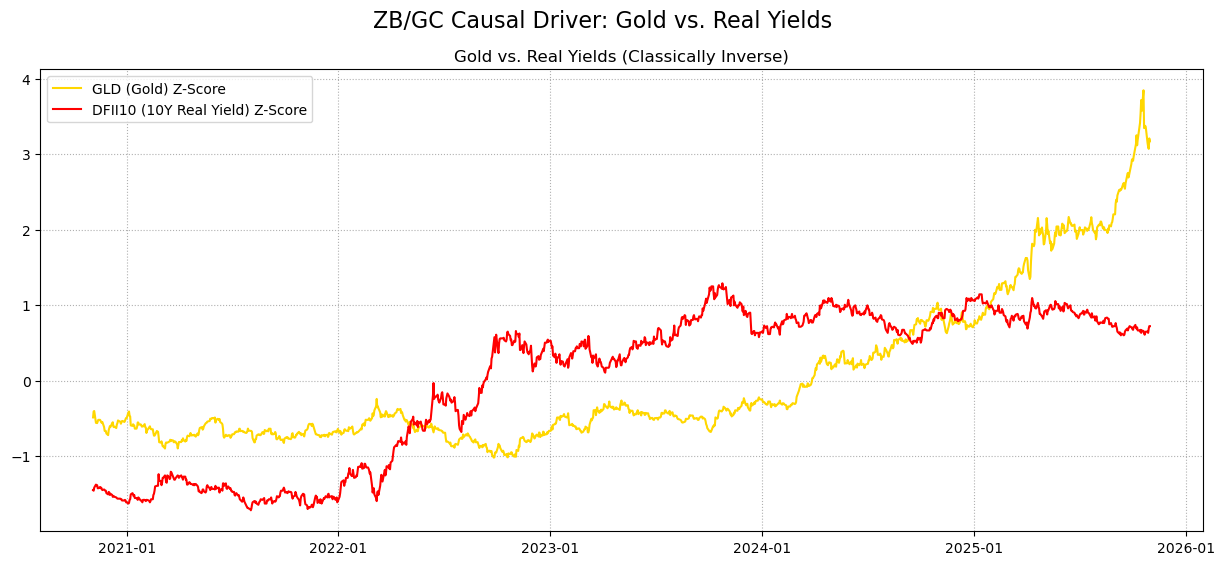

In [10]:
# Cell 10: Visualization - Causal Driver (Real Yields)
#
# Plot 1: Normalized prices of GLD vs. 10Y Real Yield (DFII10).
#
# This chart shows *why* it's happening.
# Classic relationship: INVERSE. GLD (gold) rises, DFII10 (real yield) falls.
# If they both rise together, the "safe haven" model is broken.

try:
    print("Plotting Cell 10: Causal Driver...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('ZB/GC Causal Driver: Gold vs. Real Yields', fontsize=16)

    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.plot(df_normalized.index, df_normalized['DFII10'], label='DFII10 (10Y Real Yield) Z-Score', color='red')
    ax1.set_title('Gold vs. Real Yields (Classically Inverse)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 10: Plotting failed: {e}")

Plotting Cell 11: Correlation Breakdown...


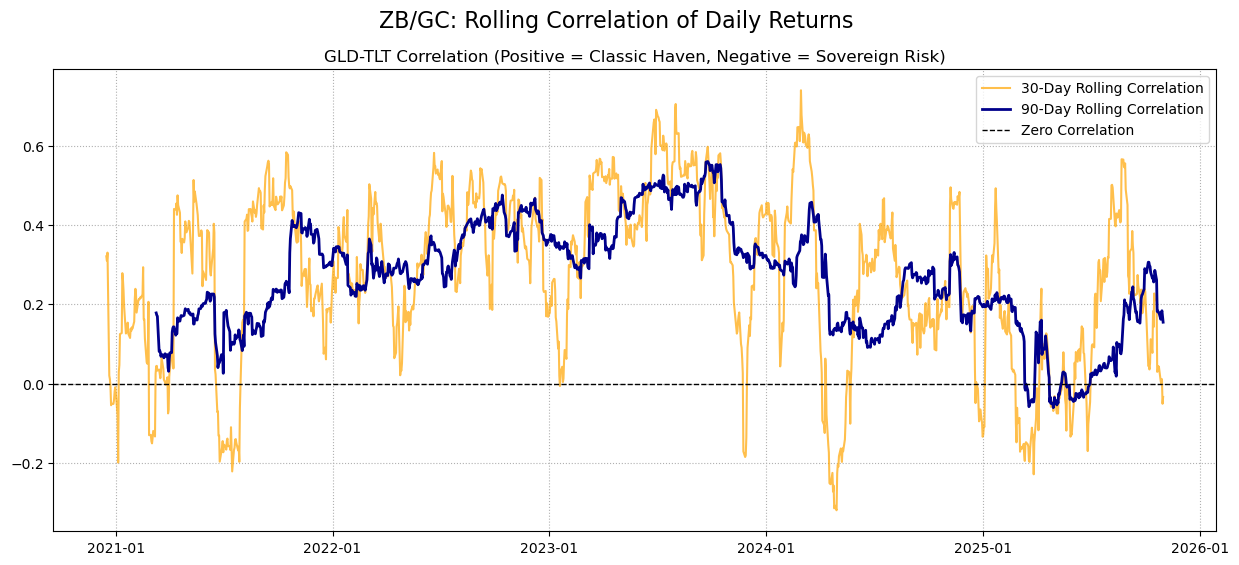

In [11]:
# Cell 11: Visualization - Correlation Breakdown
#
# Plot the 30-day and 90-day rolling correlation of returns.
#
# This chart quantifies the thesis. A positive correlation (e.g., +0.5)
# means they act as classic risk-off partners. A negative correlation
# (e.g., -0.3) means the "Sovereign Risk" thesis is in play.

try:
    print("Plotting Cell 11: Correlation Breakdown...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('ZB/GC: Rolling Correlation of Daily Returns', fontsize=16)

    ax1.plot(df.index, df['Corr_30D'], label='30-Day Rolling Correlation', color='orange', alpha=0.7)
    ax1.plot(df.index, df['Corr_90D'], label='90-Day Rolling Correlation', color='darkblue', linewidth=2)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Correlation')
    ax1.set_title('GLD-TLT Correlation (Positive = Classic Haven, Negative = Sovereign Risk)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11: Plotting failed: {e}")

In [12]:
# Cell 12: LLM Analysis & Insights
#
# Pass the most recent data to the LLM for a qualitative analysis.
# This fulfills Step 2 of your thesis: "Only public...data + your synthesis."

try:
    print("Sending data to LLM for analysis...")
    
    # Get the latest data row
    latest_data = df.iloc[-1]
    
    # Create a summary of the latest data points
    data_summary = f"""
    - **Date:** {latest_data.name.strftime('%Y-%m-%d')}
    - **GLD/TLT Price Ratio:** {latest_data['GLD_TLT_Ratio']:.2f}
    - **GLD vs. TLT (Z-Score):** GLD at {df_normalized.iloc[-1]['GLD']:.2f}, TLT at {df_normalized.iloc[-1]['TLT']:.2f}
    - **90-Day Correlation:** {latest_data['Corr_90D']:.3f}
    - **10Y Real Yield (DFII10):** {latest_data['DFII10']:.2f}%
    - **10Y Breakeven (T10YIE):** {latest_data['T10YIE']:.2f}%
    - **Dollar Index (DTWEXBGS):** {latest_data['DTWEXBGS']:.2f}
    """
    
    # Create the prompt
    prompt = f"""
    **Role:** You are an Independent Intelligence Desk Analyst, as per my thesis.
    
    **Thesis:** I am analyzing the 10-Year Treasury (/ZB or TLT) vs. Gold (/GC or GLD) relationship.
    * The **classic** regime is: "Disinflationary Risk-Off." In this regime, a crisis causes GLD and TLT prices to *rise together* (positive correlation) as investors seek havens.
    * The **new** regime is: "Stagflation / Fiscal Crisis." In this regime, U.S. fiscal concerns (deficits, inflation) cause investors to *sell* Treasuries (TLT price falls) but *buy* Gold (GLD price rises), breaking the correlation (it turns negative).
    
    **Latest OSINT Data:**
    {data_summary}
    
    **Your Task (Provide 3-bullet synthesis):**
    1.  **Regime Check:** Based on the data, which regime are we in? Is the classic correlation holding or breaking down?
    2.  **Causal Driver:** What is the primary driver? (e.g., Is Gold's move being driven by real yields (DFII10) as expected, or is it decoupling?)
    3.  **Arbitrage/Trade Idea:** Based *only* on this data, what is the clear thematic trade? (e.g., "The data suggests the divergence (rising ratio) is intact, favoring Long GLD / Short TLT," or "The data shows the relationship is mean-reverting, favoring Long TLT / Short GLD.")
    """
    
    # Get LLM response
    llm_response = ask_llm(prompt)
    
    print("\n--- 🤖 LLM INTELLIGENCE SYNTHESIS ---")
    print(llm_response)
    print("-------------------------------------")

except Exception as e:
    print(f"❌ Cell 12: LLM Analysis failed: {e}")

Sending data to LLM for analysis...

--- 🤖 LLM INTELLIGENCE SYNTHESIS ---
### 3-Bullet Synthesis

1. **Regime Check:** Based on the latest OSINT data, it appears we are transitioning from the classic disinflationary risk-off regime to a new stagflation/fiscal crisis regime. The positive correlation between GLD and TLT is breaking down, as evidenced by the negative 90-day correlation (0.155) and the rising GLD/TLT price ratio (4.08), which suggests that investors are selling Treasuries while buying Gold in response to U.S. fiscal concerns.

2. **Causal Driver:** The primary driver appears to be the real yield (DFII10) at 1.82%, as it is lower than expected, and the breakeven inflation rate (T10YIE) of 2.30% indicates rising inflation expectations. However, the decoupling in their relationship suggests that other factors such as dollar strength or broader economic concerns might also be influencing these assets independently.

3. **Arbitrage/Trade Idea:** Given the data, a clear thematic